# Frequency content: Spectrum and Frequency Filtering

**Note for next year: Look at Taj and Sean's midterm and 'from scratch' filter function as good example of how to DIY**

In order to understand spectral content, we must first examine a static tone's frequency content. That is, the frequency content of a waveform whose period nor amplitude changes over time.

For now, a useful tool for graphing or investigating the spectral (frequency) content of a sound is the `magnitude_spectrum` function from the matplotlib.pyplot library.  The function takes two arguments, a signal (s) and sampling rate or samples per unit time (N).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from scipy.signal import sawtooth, square, butter, filtfilt
from IPython.display import Audio, Image


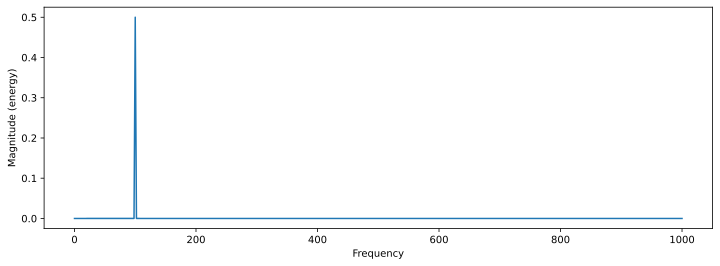

In [2]:
#create a signal:
f = 100
n = np.arange(2000)
N = 2000
s = np.cos(2 * np.pi * f * n / N) # this is our signal of f=7 and N=2000
# plot the magnitude spectrum
plt.magnitude_spectrum(s,N); #semi-colon suppresses array output

The spectral analysis measures the average energy in each frequency region over the time period of the analyzed segment. This type of analysis (or plot) is referred to as the *amplitude spectrum* or *magnitude spectrum*

A single sinusoid has only one frequency component at the fundamental value. (So all of the spectrum amplitude is showing up at 100Hz).

Let's look at a more complex tone:

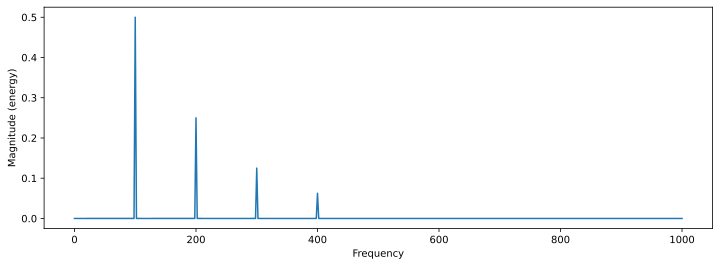

In [3]:
f = 100
n = np.arange(2000)#low sample rate for efficiency (for now)
N = 2000
s = np.cos(2 * np.pi * f * n / N) #100 Hz
s_p2 = .5 * np.cos(2 * np.pi * f*2 * n / N)#200Hz
s_p3 = .25 * np.cos(2 * np.pi * f*3 * n / N)#300Hz
s_p4 = .125 *np.cos(2 * np.pi * f*4 * n / N)#400Hz
s_out = s+s_p2+s_p3+s_p4
# plot the magnitude spectrum
plt.magnitude_spectrum(s_out,N);

In [4]:
Audio(s_out, rate=2000)

What kind of sound will we get if we arrange the frequency components such that they are no longer integer multiples?

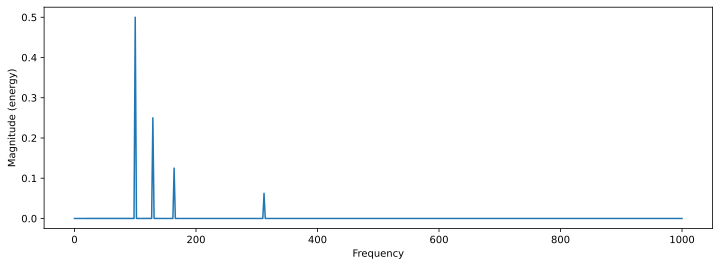

In [5]:
f = 100
n = np.arange(2000)
N = 2000
s = np.cos(2 * np.pi * f * n / N)
s_p2 = .5 * np.cos(2 * np.pi * f*1.29 * n / N)
s_p3 = .25 * np.cos(2 * np.pi * f*1.64 * n / N)
s_p4 = .125 *np.cos(2 * np.pi * f*3.12 * n / N)
s_out = s+s_p2+s_p3+s_p4
# plot the magnitude spectrum
plt.magnitude_spectrum(s_out,N);

In [6]:
Audio(s_out, rate=2000)

#### Filters control frequency response
Rather than build every sound from scratch by adding partials at various amplitudes, one way of varying the timbre of the sound is to use filters to control the **frequency response** of the output signal relative to the input.

#### Magnitude spectrum and power spectrum (technically not the same thing)
From the amplitude spectrum one can derive the power spectrum. Power is defined as the square of the amplitude of a signal. Thus, power spectrum is the square of the amplitude spectrum. Displays of spectrum sometimes show power, rather than amplitude, because this correlates better with human perception.

#### Spectrum and timbre
Spectrum and timbre are related concepts, but they are not equivalent. Spectrum is a physical property that can be characterized as a distribution of energy as a function of frequency. Timbre is a term that refers to the perceptual *quality* of a sound and is frequently (incorrectly) used interchangably with instrumentation. (An equivalent analogy is frequency, which is an acoustic term, and pitch, which is an acoustic or perceptual term.

## Filters

Let's review the most common varieties of filters:

* low-pass: attenuates frequencies above a target frequency, referred to as the "cutoff" frequency (lets low frequencies "pass through")

* high-pass: attenuates frequencies below a target frequency, referred to as the "cutoff" frequency (lets high frequencies "pass through")

* band-pass: attenuates frequencies above or below the target frequency range (effectively a low-pass and high-pass filter operating simultaneously)

* band stop: (a.k.a. notch filter) blocks and rejects frequencies that lie between its two cut-off frequency points passes all frequencies outside this range.

* EQ: boost or cut frequencies according to "bands" of the entire spectrum (note: shelving is a type of EQ)

* shelving: boost or cut energy at the target frequency and all audio frequencies either above or below it


#### EQ, a special case

The process of equalization can be modeled as a process of *adding or subtracting* a filtered version of the signal from the signal. Adding the filtered version gives a boost to the frequencies selected by the filter, whereas subtracting the filtered output reduces the frequency component amplitudes in the filter’s frequency range. 



#### Filter shape: 
Real filters do not suddenly stop passing signal components at a given frequency. Instead, there is a transition from passing the signal components to attenuating them. The cutoff frequency of a filter is usually expressed as the point at which it is attenuating the signal by 3 dB relative to the pass-band. Thus if a filter’s cutoff is set to a given frequency, there will be a region within the pass-band that affects the amplitude of the frequency components of the signal. This region can extend as far as an octave away from the cutoff point. Therefore, in practice, the filter’s cutoff frequency is commonly set *beyond* the "ideal" cutoff frequency. This is especially true when trying to minimize timbral change of a signal due to change in frequency content caused by the filter’s transition region.

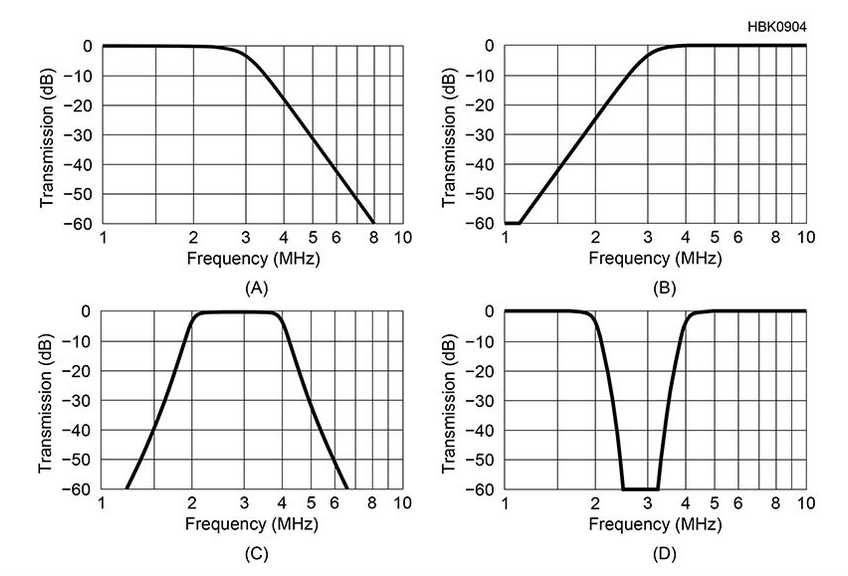

In [7]:
Image('../images/filtertypes.png')

In practicality, filters are most commonly used in signal processing to eliminate noise and artifacts.

Let's look at a signal with a lot of noise:

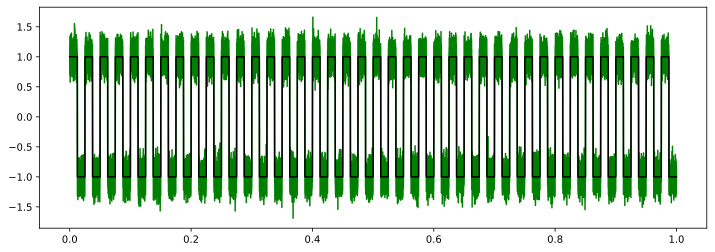

In [8]:
np.random.seed(60)   # repeatable results
f0 = 40
t = np.arange(0,1.0,1.0/44100)
mysignal = square(2*np.pi*f0*t)
mynoise = 0.15*np.random.randn(mysignal.size)

plt.plot(t, mysignal+mynoise, 'g', t, mysignal, 'black');

In [9]:
#original
Audio(mysignal, rate=44100)

In [10]:
Audio(mysignal+mynoise, rate=44100)

Here is the magnitude spectrum for the signal and noise separately:

Text(0, 0.5, 'amplitude')

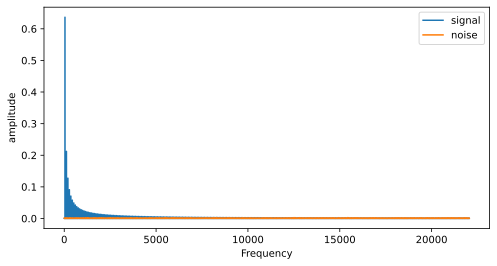

In [11]:
plt.figure(figsize=(8,4))
N=44100
plt.magnitude_spectrum(mysignal, N)
plt.magnitude_spectrum(mynoise, N)
plt.legend(('signal','noise'))
plt.ylabel('amplitude')

Notice that noise has a flat spectral shape. The difference between the signal and the noise is easier to see if you use a log scale:

Text(0, 0.5, 'amplitude in dBFS')

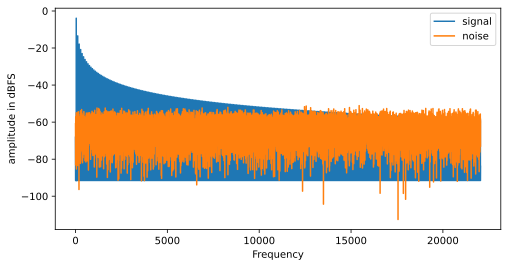

In [12]:
plt.figure(figsize=(8,4))
N=44100
plt.magnitude_spectrum(mysignal,N, scale='dB')
plt.magnitude_spectrum(mynoise,N, scale='dB')
plt.legend(('signal','noise'))
plt.ylabel('amplitude in dBFS')

...Let's come back to our noisy signal in a bit.

We will be making use of a filter in the scipy package: `scipy.signal.butter` 

A Butterworth filter is a common type of signal processing filter designed to have a frequency response as flat as possible in the passband. It is therefore also referred to as a maximally flat magnitude filter.

It has an amplitude response of:

$\lvert mag \lvert = \frac{1}{\sqrt{1+\frac{\omega}{\omega_c}} ^{2n}}$

where $\omega_c$ is the cutoff frequency, and $n$ refers to the filter *order* (see graph below)

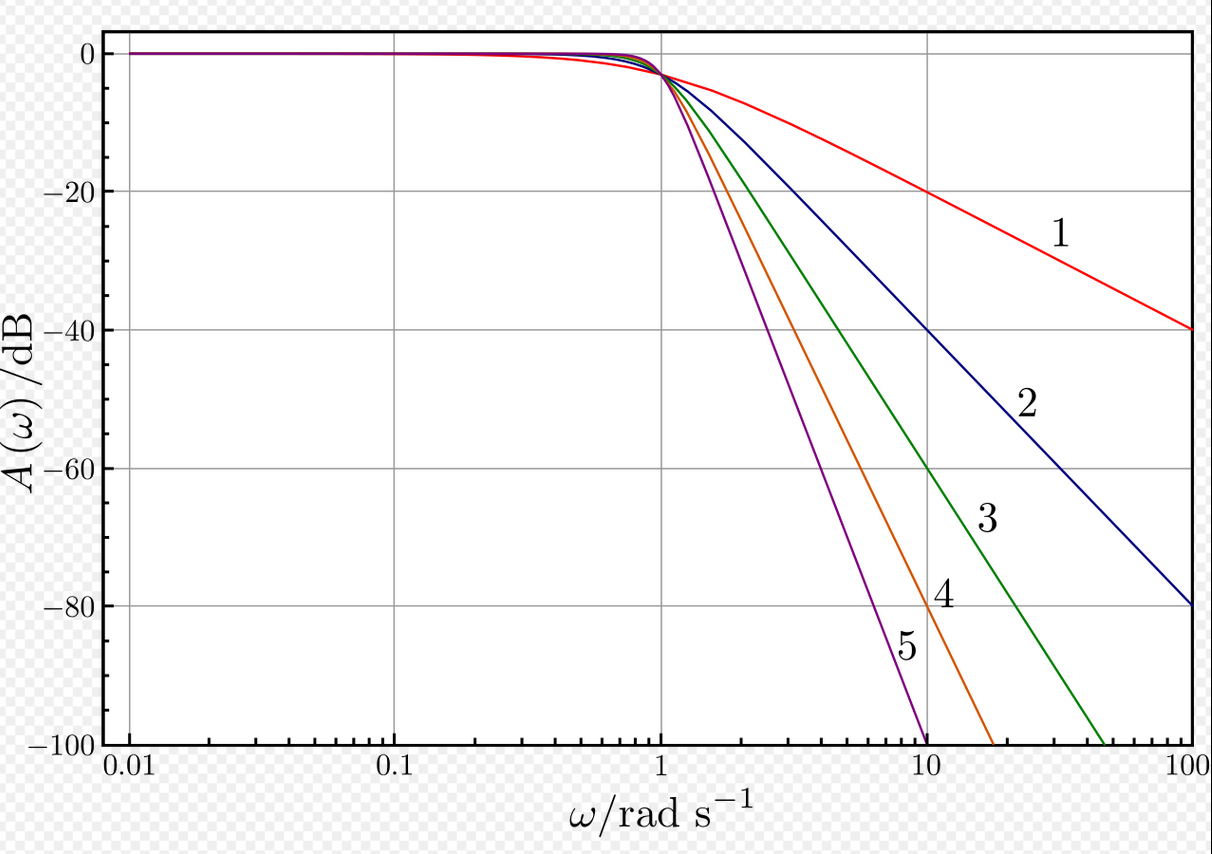

In [15]:
Image('../images/butterworth.png', width=700)

As the order of the filter increases, both the slope of the attenuation as a function of frequency and the sharpness of the cutoff increase; this reduces the *transition region* effects but, unfortunately, increases the *time domain effects.*

#### Filter time-domain effects...

Time domain effects: Filters also have a response in the time domain. Any form of filtering that reduces the bandwidth of the signal will also spread it over a longer period of time. These time domain effects are usually most pronounced near the cutoff frequency and become worse as the cutoff becomes sharper. Again, as in the case of filter shape, these effects can extend well into the pass-band of the filter.

#### Examples

Let's look at some code where we set up our filter:

In [70]:
def butter_filter_coef(cutoff, fs=44100, order=5, btype='lowpass'):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
#     if btype =='bandpass':
#         low = cutoff[0]/ nyq
#         high = cutoff[1] / nyq
#         cutoff=[low,high]
#     else: cutoff=cutoff
    (b, a) = butter(order, cutoff, btype=btype, analog=False, fs=fs)
    #output of butter function is (b,a) or 'numerator, denominator.' I.e., returns the filter coefficients
    return (b, a)

def butter_filter(data, cutoff, fs=44100, order=5, btype='lowpass'):
    (b, a) = butter_filter_coef(cutoff, fs=fs, order=order, btype=btype) 
    y = filtfilt(b, a, data)
# def butter_bandpass(lowcut, highcut, fs, order=5):
#     nyq = 0.5 * fs
#     low = lowcut / nyq
#     high = highcut / nyq
#     b, a = butter(order, [low, high], btype='bandpass')
#     return b, a

# def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
#     b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#     y = filtfilt(b, a, data)
#     return y
#     y = filtfilt(b, a, data)
#     return y


Let's compare a signal before and after filtering:

(0.0, 5000.0)

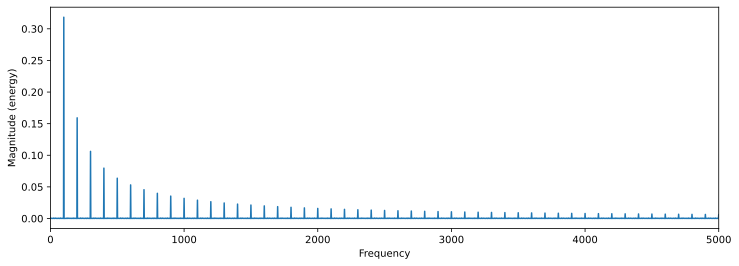

In [66]:
f = 100
n = np.arange(44100)
N = 44100
s = sawtooth(2 * np.pi * f * n / N) # note: sawtooth wave

plt.figure(figsize=(12,4))

plt.magnitude_spectrum(s, N)
plt.xlim(0,5000)

In [67]:
Audio(s, rate=44100)

In [68]:
s2 = butter_filter(data=s, cutoff=1000, fs=44100, order=5, btype='lowpass')
#plt.figure(figsize=(9,4))
type(s2)
#plt.magnitude_spectrum(s2, N)
#plt.xlim(0,5000)

NoneType

In [69]:
Audio(s2, rate=44100)

ValueError: No audio data found. Expecting filename, url, or data.

We can use this filter to apply ‘lowpass’, ‘highpass’, ‘bandpass’, or ‘bandstop’ by changing the argument value for `btype`

TypeError: object of type 'NoneType' has no len()

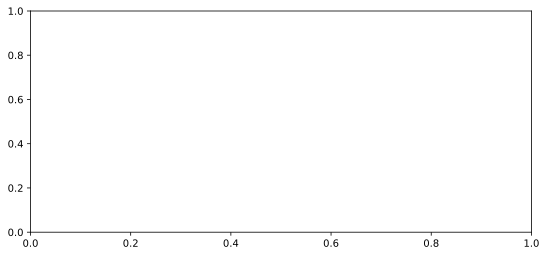

In [57]:
#recall s = 100 Hz sawtooth
N=44100
s3 = butter_filter(data=s, cutoff=500.0, fs=44100, order=5, btype='highpass')
plt.figure(figsize=(9,4))

plt.magnitude_spectrum(s3, N)
plt.xlim(0,5000)
plt.ylim(0,0.4)


In [23]:
Audio(s3, rate=44100)

In [ ]:
N=44100
s4 = butter_filter(data=s, lowcut=200.0,highcut=800, fs=44100, order=5,btype='bandpass')

plt.magnitude_spectrum(s4, N)
plt.xlim(0,5000)
plt.ylim(0,0.4)

In [24]:
Audio(s4, rate=44100)

NameError: name 's4' is not defined

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
def butter_bandstop(lowcut, highcut, fs, order):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='bandstop')
        return b,a

def butter_bandstop_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandstop(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

Note: some odd behavior happening with bandstop. Just use other filters for now while I troubleshoot.